In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np
import math
import scipy.optimize

import jabble.dataset
import jabble.loss
import jabble.model

import matplotlib.pyplot as plt

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


<h1>44 - simple data varying splines n lines</h1>


In [2]:
import os
import datetime
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%d-%m-%y"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
def gaussian(x,mu,sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) #/ (2 * sigma * np.sqrt(2 * np.pi))

In [4]:
resolution = 120_000
snr        = 100
epoches    = 20

dx = jabble.dataset.delta_x(2*resolution)
lmin = 4530
lmax = 4540
transformation_value = lmin
x_grid    = np.arange(np.log(lmin/lmin),np.log(lmax/lmin),step=dx,dtype='float64')

wave_grid = np.exp(x_grid) * u.Angstrom

guess_vel  = np.linspace(-60,60,epoches) * u.km/u.s
extra_vel  = np.linspace(-30,30,epoches)  * u.m/u.s
velocities = guess_vel + extra_vel
shifts     = jabble.dataset.shifts(velocities).value

means_set = [np.log(np.random.uniform(4532,4537.3,n**2)/transformation_value) for n in range(2,3)]
heigt_set = [np.random.uniform(0.3,0.7,n**2) for n in range(2,3)]

nargs = [200]
normalize = scipy.ndimage.gaussian_filter
def create_dataset(means,heights):
    
    flux = np.ones((epoches,*wave_grid.shape),dtype='float64') 
    print(type(shifts),type(dx),type(x_grid))
    for i,mean in enumerate(means):
        flux -= heights[i] * gaussian(np.repeat((x_grid)[np.newaxis,:],epoches,axis=0),np.repeat((mean + shifts)[:,np.newaxis],wave_grid.shape[0],axis=1),dx)

    # add noise
#     for j in range(flux.shape[0]):
#         for k in range(flux.shape[1]):
#             flux[j,k] -= np.random.normal(0.0,np.abs(flux[j,k]/snr))
    ferr = flux/snr

    
    dataset = jabble.dataset.Dataset.from_flux(np.repeat((wave_grid)[np.newaxis,:],epoches,axis=0),flux,ferr,mask=np.ones(flux.shape),normalize=normalize,nargs=nargs)
    return dataset

In [5]:
datasets = [create_dataset(mean,heights) for mean,heights in zip(means_set,heigt_set)]

<class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.ndarray'>


In [6]:
means_set[0]

array([0.00105658, 0.0015536 , 0.00052149, 0.0015438 ])

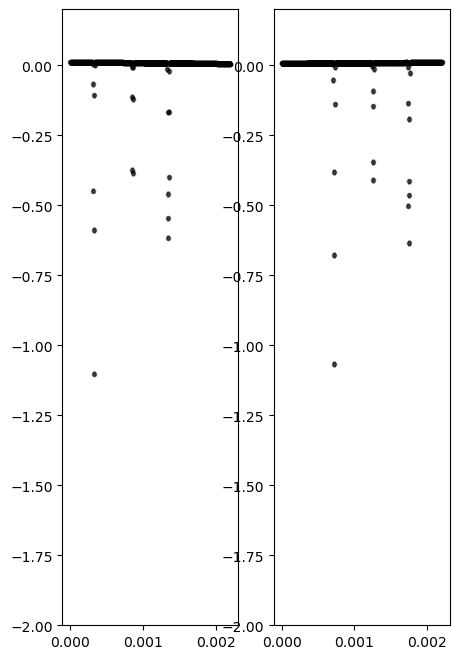

In [7]:
plt_inds = epoches
xpmin = np.log(4550)
xpmax = np.log(4560)
fig, axes = plt.subplots(len(datasets),2,figsize=(5,8))
for i,dataset in enumerate(datasets):
    axes[0].errorbar(dataset.xs[0,:],dataset.ys[0,:],dataset.yerr[0,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
    axes[1].errorbar(dataset.xs[-1,:],dataset.ys[-1,:],dataset.yerr[-1,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)

#     axes[ele].set_xlim(xpmin-shifts[ele],xpmax-shifts[ele])
    axes[0].set_ylim(-2,0.2)
    axes[1].set_ylim(-2,0.2)
plt.show() 

In [8]:
type(dataset.xs), type(dataset.ys), type(dataset.mask), type(dataset.yivar)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [9]:
loss = jabble.loss.ChiSquare()
init_vels   = guess_vel
init_shifts = jabble.dataset.shifts(init_vels)

In [10]:
init_shifts.dtype

dtype('float64')

In [11]:
import jax

In [12]:
from collections import namedtuple

In [13]:
from jaxopt import GaussNewton
import jax.numpy as jnp

class MyModel(jabble.model.CompositeModel):
    def grad_descent(self,loss,data,verbose=False,options={},save_history=False,save_loss=False,*args):
        # Fits the Model
        self.save_history = save_history
        self.save_loss    = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])

        func_grad = jax.value_and_grad(loss.loss_all, argnums=0)
        def val_gradient_function(p,*args):
            val, grad = func_grad(p,*args)
            self.func_evals.append(val)
            if verbose:
                print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))

            if self.save_history:
                self.history.append(np.array(p))

            if self.save_loss:
                initialize = loss(p,data,0,self)
                tmp        = np.zeros((data.ys.shape[0],*initialize.shape))
                tmp[0,...] = initialize
                for i in range(1,data.ys.shape[0]):
                    tmp[i,...] = loss(p,data,i,self)
                self.loss_history.append(tmp)

            return np.array(val,dtype='float64'),np.array(grad,dtype='float64')

        res = grad_descent(val_gradient_function, self.get_parameters(), data, self, options=options)
        self.results.append(res)
        self.unpack(res.x)
        return res
    
    def gaussnewton(self,data,verbose=False,save_history=False,save_loss=False,*args):
        # Fits the Model
        self.save_history = save_history
        self.save_loss    = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])
        def chi_1(p):
            residual = jnp.zeros(data.xs.shape)
            for i in range(data.xs.shape[0]):
                
                residual = residual.at[i,:].set((data.ys[i,:] - self(p,data.xs[i,:],i)) * data.yivar[i,:])
            return residual
        
        
#         func_grad = jax.value_and_grad(chi_1, argnums=0)
#         def val_gradient_function(p,*args):
#             val, grad = func_grad(p,*args)
#             self.func_evals.append(val)
#             if verbose:
#                 print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))

#             if self.save_history:
#                 self.history.append(np.array(p))

        gn = GaussNewton(residual_fun=chi_1)
        gn_sol = gn.run(self.get_parameters())
        
        self.results.append(gn_sol)
        self.unpack(gn_sol.params)
        return gn_sol
    
    def new_lbfgsb(self,loss,data,verbose=False,save_history=False,save_loss=False,**options):
        # Fits the Model
#         self.save_history = save_history
#         self.save_loss    = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])

        func_grad = jax.value_and_grad(loss.loss_all, argnums=0)
        def val_gradient_function(p,*args):
            val, grad = func_grad(p,*args)
            self.func_evals.append(val)
            if verbose:
                print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))

            if self.save_history:
                self.history.append(np.array(p))

            if self.save_loss:
                initialize = loss(p,data,0,self)
                tmp        = np.zeros((data.ys.shape[0],*initialize.shape))
                tmp[0,...] = initialize
                for i in range(1,data.ys.shape[0]):
                    tmp[i,...] = loss(p,data,i,self)
                self.loss_history.append(tmp)

            return np.array(val,dtype='f8'),np.array(grad,dtype='f8')

        x, f, d = scipy.optimize.fmin_l_bfgs_b(val_gradient_function, self.get_parameters(), None, (data, self))
        self.results.append(d)
        self.unpack(x)
        return d

In [14]:
dataset.xs.shape

(20, 530)

In [15]:
class MyShiftingModel(jabble.model.ShiftingModel):
    def grid_search(self,grid,loss,model,data,epoches=None):
        if epoches is None:
            epoches = slice(0,self.n)
        # put all submodels in fixed mode except the shiftingmodel
        # to be searched then take loss of each epoch
        # that we hand the loss a slice of the shift array
        # since at __call__ itll on take the shift_grid[i,j] element
        model.fix()
        # index is the index of the submodel to grid search this is redundant
        self.fit(epoches=epoches)
        if isinstance(model,jabble.model.ContainerModel):
            model.get_parameters()
        # this is called because this resets the parameters per model
        # array
        # I want to have this be done when a submodel is put into fix or fix mode
        loss_arr = np.empty(grid.shape)
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                # print(shift_grid[:,j].shape)
                out = loss(grid[:,j],data,i,model)
#                 print(out.shape)
                loss_arr[i,j] = np.sum(out)
        return loss_arr

In [16]:
# from functools import partial
# from jax import jit
# def _sparse_design_matrix(x,xp,dx,basis):
#     from jax.experimental import sparse
#     '''
#         Internal Function for general_interp_simple
#         to do:
#         make sparse using 'a' and fast
#         choose fast sparse encoding
#         the fastest for lstsq solve
#         time all
#     '''
#     input = (x[None,:] - xp[:,None])/dx
#     # cond1 = jnp.floor(input) < -a
#     # cond2 = jnp.floor(input) >  a
#     # input[(cond1 + cond2).astype(bool)] = 0.0
#     # spinput = sparse.BCOO.fromdense(input)

#     return basis(input)

# @partial(jit,static_argnums=[3,4])
# def general_interp_loose(x, xp, ap, basis):
#     '''XP must be equally spaced
#         deal boundary conditions 0D, 0N
#         padding points
#         with user inputs values

#         for future test for a, where basis function goes to zero
#     '''
#     dx = xp[1] - xp[0]
#     # a = int((p+1)//2)
#     # GET EXACT SPACING from XP
# #     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
# #     X    = _sparse_design_matrix(xp,xp,dx,basis,a)

#     # This is a toeplitz matrix solve, may be faster also sparse
#     # make sparse scipy jax function maybe
# #     alphas,res,rank,s = jnp.linalg.lstsq(X,fp)

#     return (ap[:,None] * _sparse_design_matrix(x,xp,dx,basis)).sum(axis=0)

In [17]:
def _irwin_recursion(j,k,n):
    if k == 0:
        if j < n-1:
            return 0.0
        else:
            return 1.0
    
    return _irwin_recursion(j,k-1,n) + ((-1)**(n+k-j-1) * math.comb(n,k) * math.comb(n-1,j) * k**(n-j-1))

class IrwinHall:
    def __init__(self,n):
        n += 1
        self.n = n
        self.alphas = np.zeros((n,n))
        for j in range(n):
            for k in range(n):
                self.alphas[j,k] = _irwin_recursion(j,k,n)
        self.alphas = jnp.array(self.alphas)
        
    def __call__(self,x,*args):
        ks = jnp.floor(x + (self.n/2)).astype(int)
        cond1 = ks >= 0
        cond2 = ks <= (self.n-1)
        
#         indices = jnp.argwhere(cond1*cond2,size=(self.n+1)*x.shape[1])
#         print(indices.shape)
#         f       = sparse.BCOO((jnp.polyval(self.alphas[::-1,ks[indices].flatten()],\
#                                            x[indices].flatten() + (self.n/2)),\
#                                indices))
        
        f = jnp.where((cond1 * cond2), \
                      jnp.polyval(self.alphas[::-1,ks],x + (self.n/2)), \
                      0.0)
        
        return f
    
class IrwinHallModel_full(jabble.model.Model):
    def __init__(self,xs,p_val=2,p=None):
        super(IrwinHallModel_full,self).__init__()
        # when defining ones own model, need to include inputs as xs, outputs as ys
        # and __call__ function that gets ya ther, and params (1d ndarray MUST BE BY SCIPY) to be fit
        # also assumes epoches of data that is shifted between
        self.spline = IrwinHall(p_val)
        self.p_val = p_val
        self.xs = xs
        if p is not None:
            if p.shape == self.xs.shape:
                self.p = p
            else:
                logging.error('p {} must be the same shape as x_grid {}'.format(p.shape,xs.shape))
        else:
            self.p = np.zeros(xs.shape)

    def call(self,p,x,*args):
        
        y = jabble.model.cardinal_basis_full(x, self.xs, p, self.spline)
        return y

class IrwinHallModel_sparse(IrwinHallModel_full):

    def call(self,p,x,*args):
        
        a = (self.p_val+1)/2
        y = jabble.model.cardinal_basis_sparse(x, self.xs, p, self.spline, a)
        return y

In [18]:
vel_padding = 100 * u.km/u.s
model_grid = jabble.model.create_x_grid(x_grid,vel_padding,2*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
model_set = [MyModel([MyShiftingModel(init_shifts),IrwinHallModel_sparse(model_grid,i)]),\
             MyModel([MyShiftingModel(init_shifts),IrwinHallModel_full(model_grid,i)])]# for j in range(len(datasets))]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [19]:
model_set[0][0].p.dtype

dtype('float64')

In [20]:
def grad_descent(val_grad,p,data,model,options):
    
    res = namedtuple('Results', ['x','jac'])
    iteration = 1
    grad = [1e99]
    
#     anneal = 1./np.e
    while np.inner(grad,grad) > options['condition']:
        val, grad = val_grad(p,data,model)
        delta_x   = grad*options['size']#*anneal**(iteration-1)
        print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))
        p         -= delta_x
        iteration += 1
        if options['maxiter'] < iteration:
            print('maxiter reached')
            break
        
    res.x = p
    res.jac = grad
    return res

In [21]:
def train_cycle(model,dataset,loss):
    n_cycles = 1

    options1 = {'pgtol': 0.0}
    options2 = {'pgtol': 0.0}
    for iii in range(n_cycles):
        # Fitting Round 1
        print('fitting round {} 1'.format(iii))
        model.fix()
        model.fit(1)
        res1 = model.new_lbfgsb(loss,dataset,options=options1)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
        
        # # Fitting Round 2
        # print('fitting round {} 2'.format(iii))
        # model.fix()
        # model.fit(0)
        # res1 = model.new_lbfgsb(loss,dataset,options=options2)
        # print(res1['warnflag'],res1['nit'])
        # if res1['warnflag'] == 2:
        #     print(res1['task'])
            
        # # Fitting Round 3
        # print('fitting round {} 3'.format(iii))
        # model.fix()
        # model.fit(0)
        # model.fit(1)
        # res1 = model.new_lbfgsb(loss,dataset,options=options2)
        # print(res1['warnflag'],res1['nit'])
        # if res1['warnflag'] == 2:
        #     print(res1['task'])
        
    return model

In [22]:
model_set

[<__main__.MyModel at 0x15159c06b550>, <__main__.MyModel at 0x15159c023a90>]

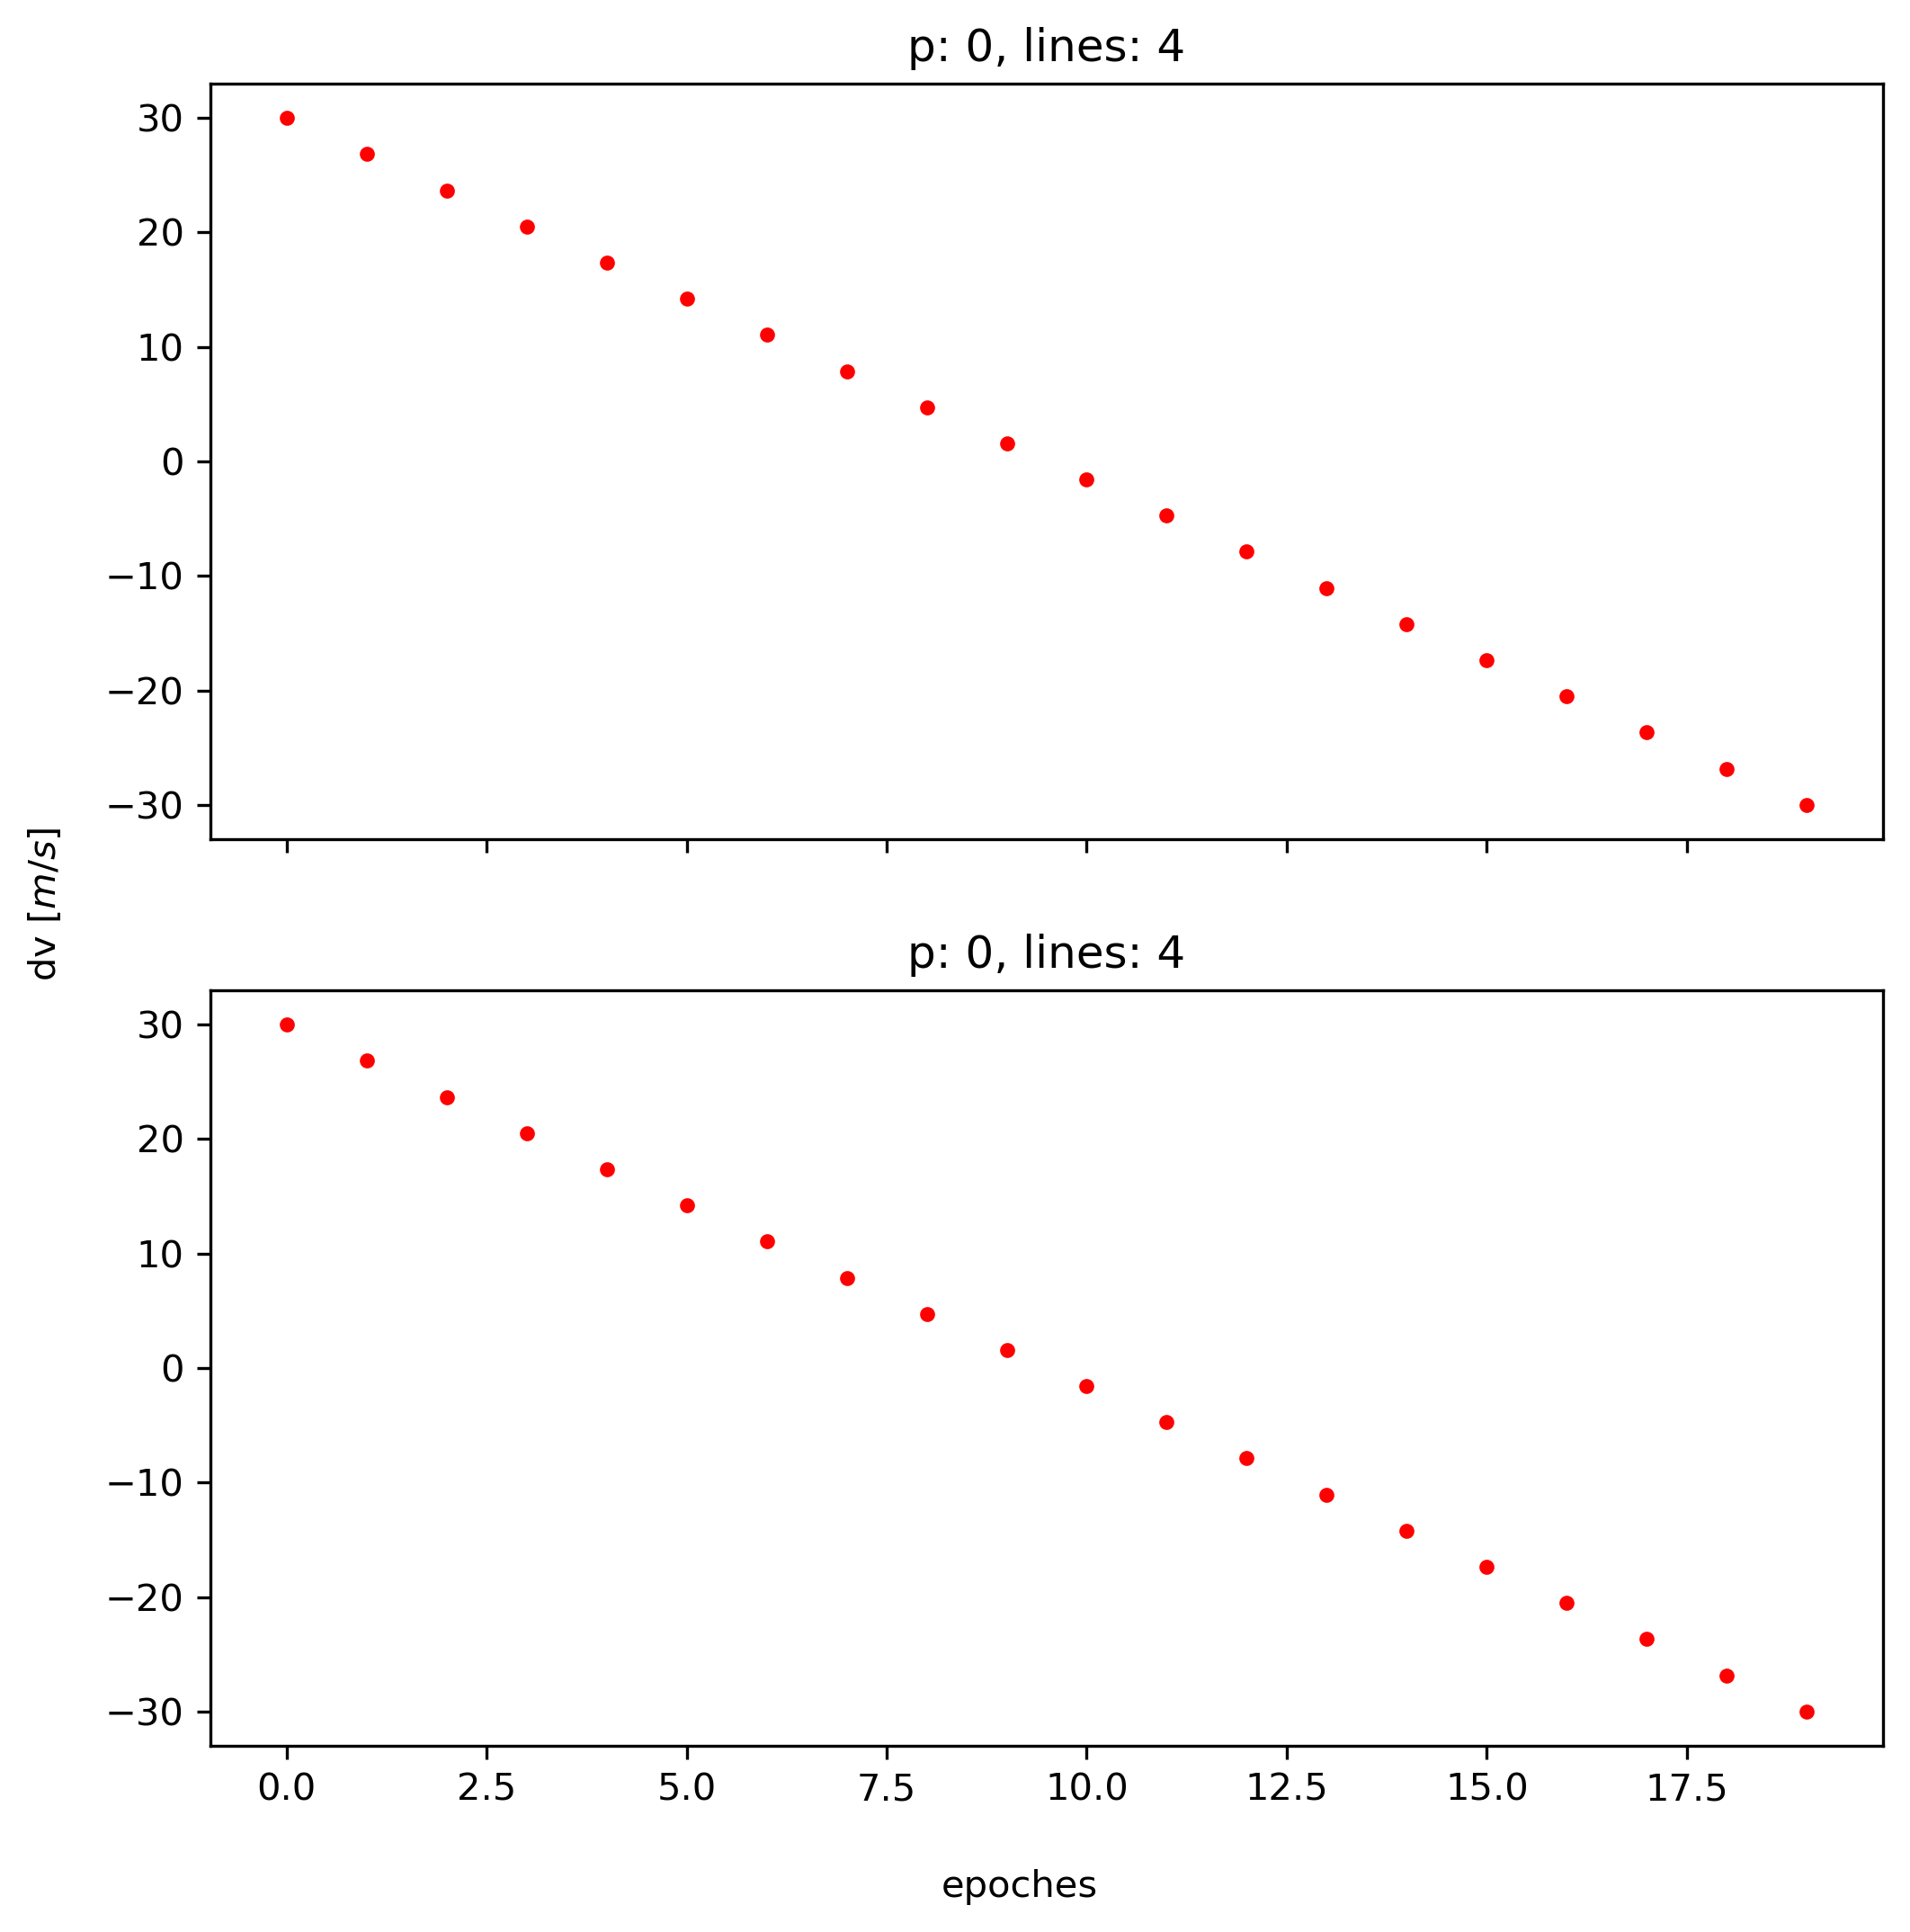

In [23]:
fig,ax = plt.subplots(len(model_set),len(datasets),figsize=(8,8),facecolor=(1,1,1),dpi=300,sharex=True,sharey=True)

epoch_range = np.arange(0,epoches,dtype=int)
# ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')

for i in range(len(model_set)):
    for j in range(len(datasets)):
        estimate_vel = jabble.dataset.velocities(model_set[i][0].p)
        dv = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean() - velocities.to(u.m/u.s).value
        ax[i].plot(epoch_range,dv,'.r',label='estimation')
        ax[i].set_title('p: {}, lines: {}'.format(model_set[i][1].p_val,len(means_set[j])))
        # ax.set_ylim(-5.5e3,5.5e3)
        # for epoch in epoch_range:
        #     constant = 1e-5
        #     ax.arrow(epoch,dv[epoch],0.0,constant*stellar_model.results[-1].jac[epoch])

        # twin_ax = ax.twinx()
        # twin_ax.plot(stellar_model.results[-1]['jac'][:stellar_model[0].p.shape[0]],'om',alpha=0.3,label='gradient')
        # twin_ax.set_ylim(-1e9,1e9)
# plt.ylabel('dv [m/s]')
# plt.xlabel('epoches')
# plt.legend()
fig.text(0.04, 0.5, 'dv [$m/s$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'epoches', ha='center')
plt.savefig(os.path.join(out_dir,'44-dv.png'))
plt.show()

In [24]:
import cProfile, pstats, io
from pstats import SortKey

In [27]:
LINE_PROFILE = 1

In [28]:
for i in range(len(datasets)):
    for j in range(len(model_set)):
        # pr = cProfile.Profile()
        # pr.enable()
        print('pval: ',model_set[i][1].p_val,'ds: ',i)
        model_set[j] = train_cycle(model_set[j],datasets[i],loss)
        # pr.disable()
        # s = io.StringIO()
        # sortby = SortKey.CUMULATIVE
        # ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        # ps.print_stats()
        # print(s.getvalue())

pval:  0 ds:  0
fitting round 0 1
0 2
pval:  0 ds:  0
fitting round 0 1
0 2


TypeError: 'MyShiftingModel' object is not subscriptable

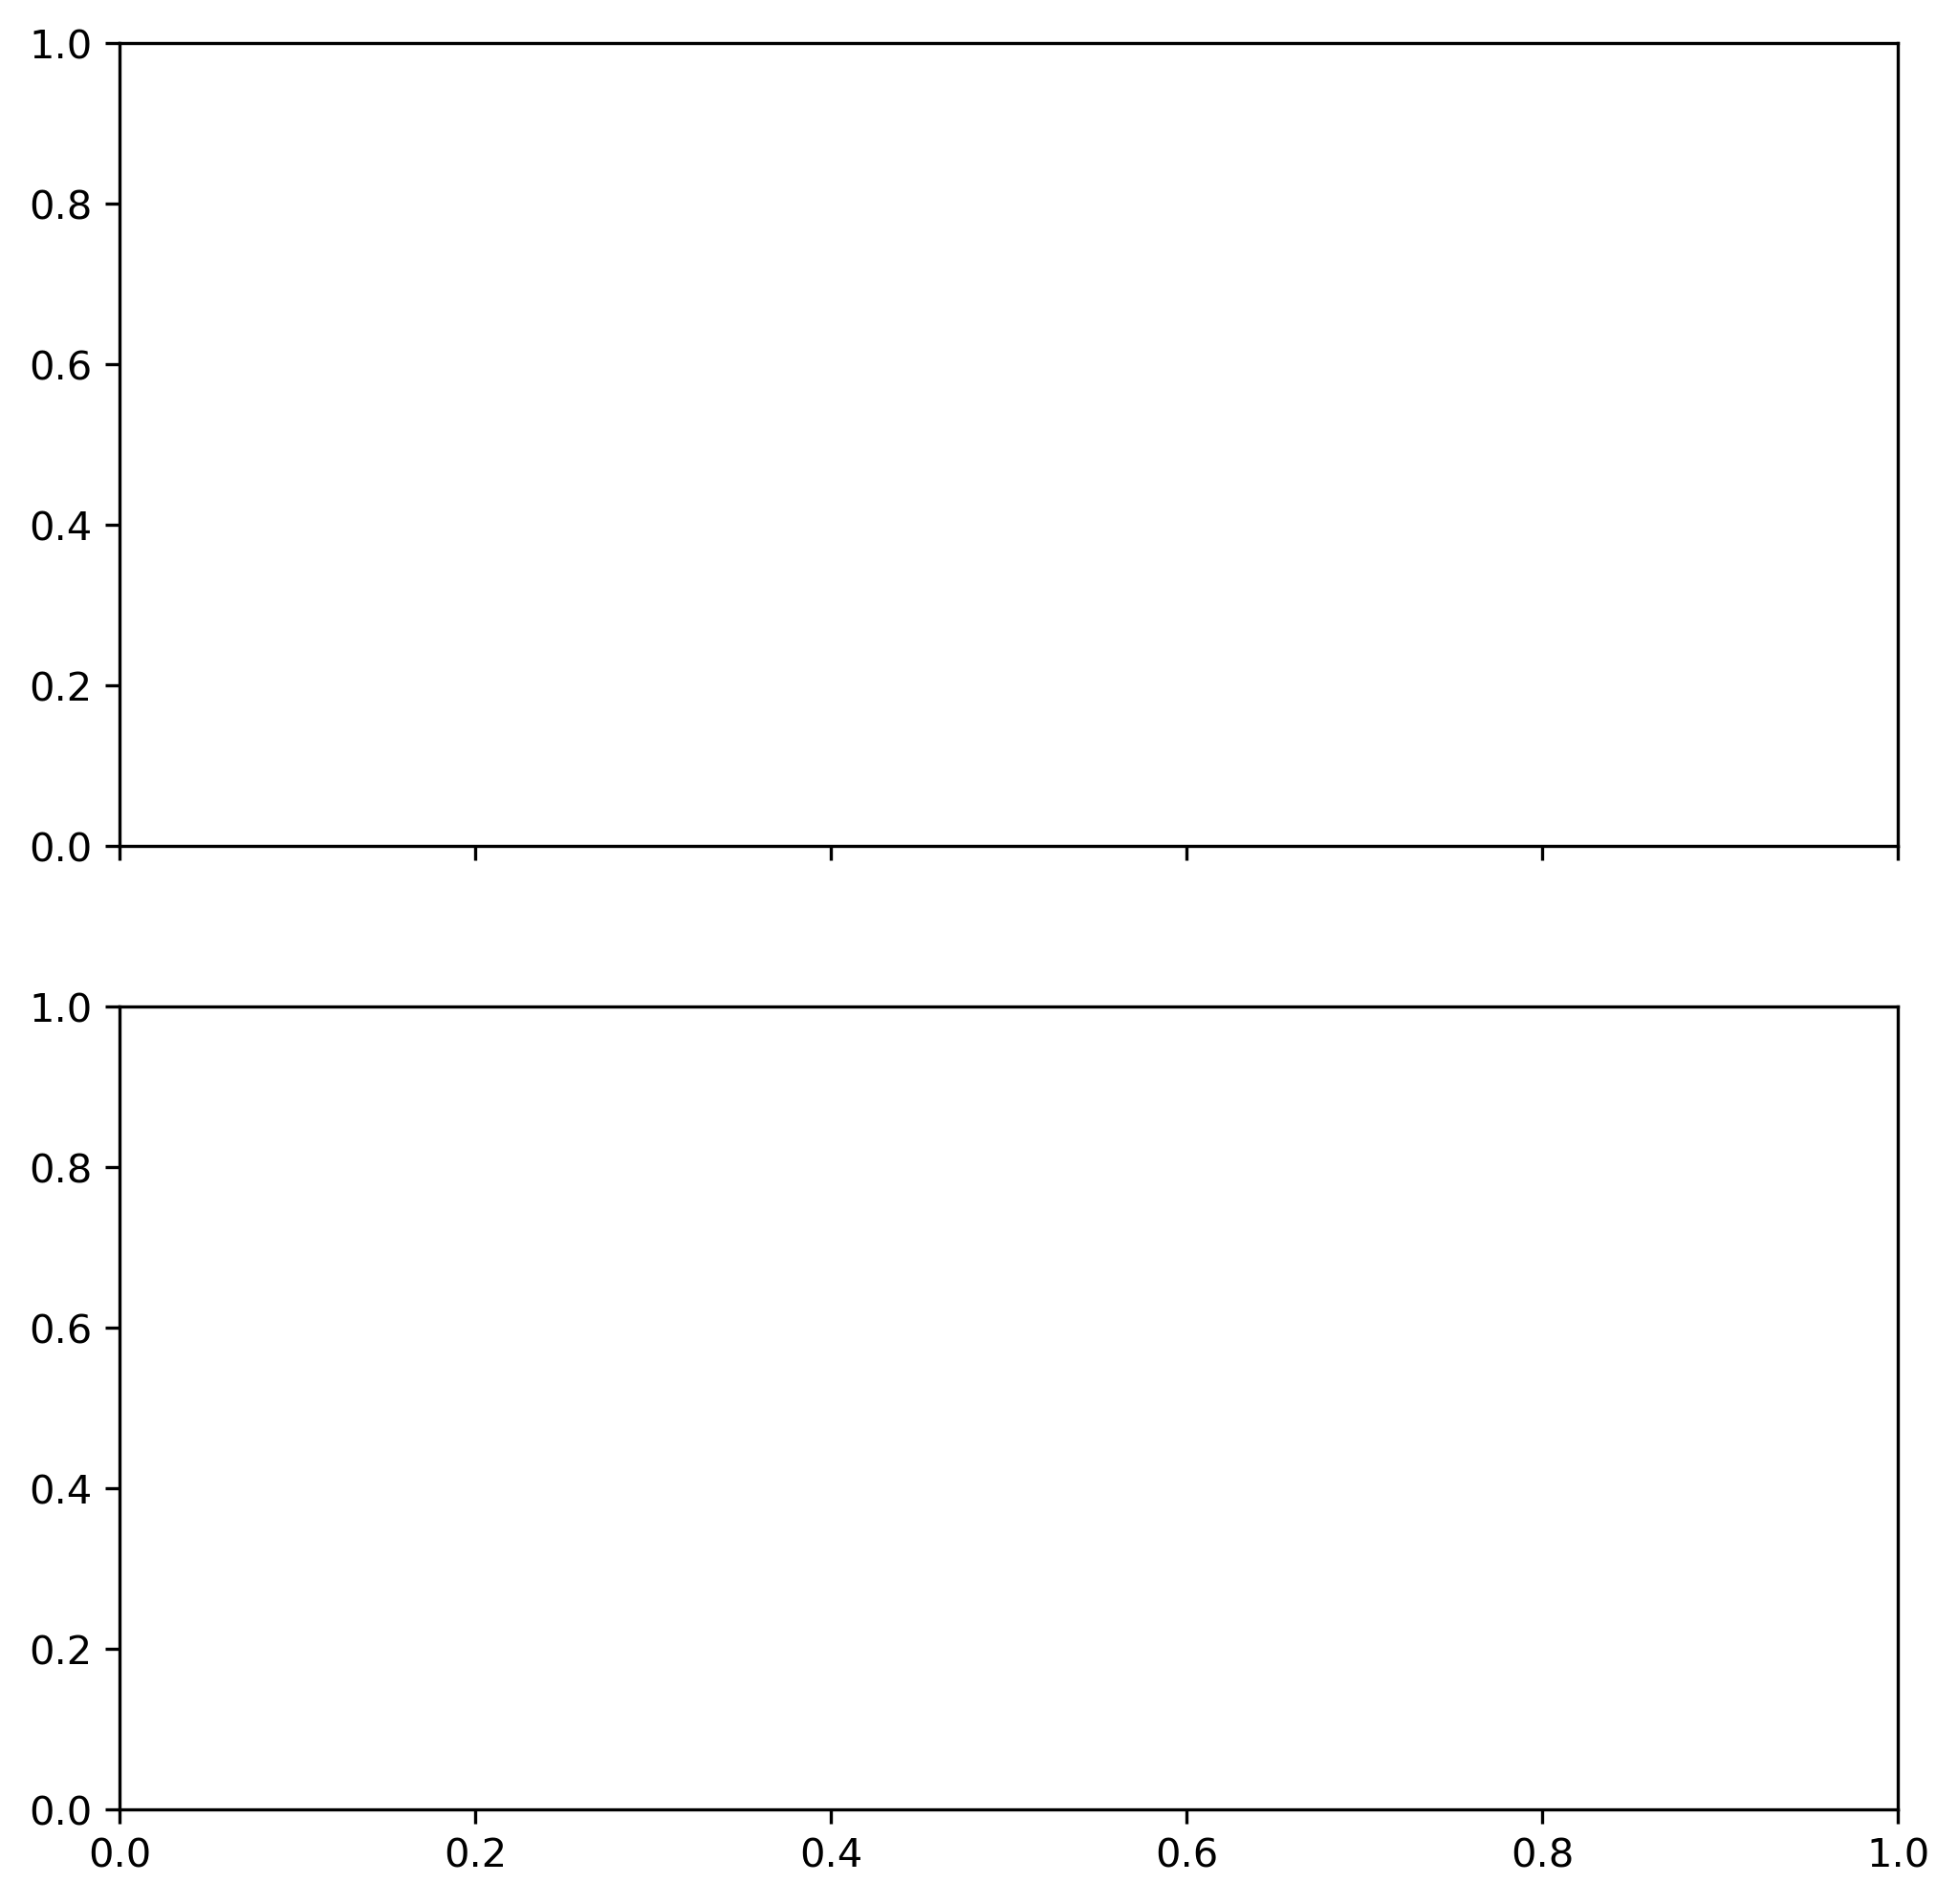

In [26]:
fig,ax = plt.subplots(len(model_set),len(datasets),figsize=(8,8),facecolor=(1,1,1),dpi=300,sharex=True,sharey=True)

epoch_range = np.arange(0,epoches,dtype=int)
# ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')

for i in range(len(model_set)):
    for j in range(len(datasets)):
        estimate_vel = jabble.dataset.velocities(model_set[i][j][0].p)
        dv = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean() - velocities.to(u.m/u.s).value
        ax.plot(epoch_range,dv,'.r',label='estimation')
        ax.set_title('p: {}, lines: {}'.format(model_set[i][j][1].p_val,len(means_set[i])))
        # ax.set_ylim(-5.5e3,5.5e3)
        # for epoch in epoch_range:
        #     constant = 1e-5
        #     ax.arrow(epoch,dv[epoch],0.0,constant*stellar_model.results[-1].jac[epoch])

        # twin_ax = ax.twinx()
        # twin_ax.plot(stellar_model.results[-1]['jac'][:stellar_model[0].p.shape[0]],'om',alpha=0.3,label='gradient')
        # twin_ax.set_ylim(-1e9,1e9)
# plt.ylabel('dv [m/s]')
# plt.xlabel('epoches')
# plt.legend()
fig.text(0.04, 0.5, 'dv [$m/s$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'epoches', ha='center')
plt.savefig(os.path.join(out_dir,'44-dv.png'))
plt.show()

In [ ]:
def norm_func(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low/y

In [ ]:
out_dir

In [ ]:
model_set[i][j].fix()
model_set[i][j].fit(0)
plt_epoch = 10
rv_deriv = jax.jacfwd(loss, argnums=0)(model_set[i][j].get_parameters(),datasets[i],plt_epoch,model_set[i][j])

In [ ]:
model_set[i][j].fix()
model_set[i][j].fit(1)
plt_epoch = 10
ctrl_deriv = jax.jacfwd(loss, argnums=0)(model_set[i][j][1].get_parameters(),datasets[i],plt_epoch,model_set[i][j][1])

In [ ]:
rv_deriv.shape, x_grid.shape, model_set[0][0][1].xs.shape, ctrl_deriv.shape

In [ ]:
lmin = 4530
lmax = 4550
x_window = np.log(4550/transformation_value) - np.log(4549/transformation_value)


lrange = np.arange(lmin,lmax,2)
plt_unit = u.Angstrom
plt_epoch = 10
fig, axes = plt.subplots(len(model_set),len(datasets),figsize=(5,5),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
for i in range(len(model_set)):
    for j in range(len(datasets)):
        
        model_set[i][j].fix()
        model_set[i][j].fit(0)
        rv_deriv = jax.jacfwd(loss, argnums=0)(model_set[i][j].get_parameters(),datasets[i],plt_epoch,model_set[i][j])
        
        model_set[i][j].fix()
        
        axes.errorbar(datasets[i].xs[plt_epoch,:],datasets[i].ys[plt_epoch,:],\
                                 datasets[i].yerr[plt_epoch,:],fmt='.k',\
                                 elinewidth=2.2,zorder=3,alpha=0.8,ms=6)
    #     axes[j%yax, j//yax].plot(stellar_model[1].xs+stellar_model[0].p[j],\
    #                          stellar_model[1].p,\
    #                          '.r',linestyle='solid',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
        xplot = np.linspace(np.log(lmin/transformation_value),np.log(lmax/transformation_value),5000)
        axes.plot(xplot,model_set[i][j]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)

        axes.set_ylim(-2,1)
#         axes[i,j].set_yticks([])
        axes.set_xticks(np.log(lrange/transformation_value))
        axes.set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        axes.set_xlim(np.mean(means_set[i][0])-x_window+model_set[i][j][0].p[plt_epoch],np.mean(means_set[i][0])+x_window+model_set[i][j][0].p[plt_epoch])

        res_ax = axes.twinx()
    #     res_ax.set_yticks([])
    #     res_ax = axes[j%2,j//2].twinx()
    #     residual = loss(stellar_model.get_parameters(),dataset,j,stellar_model)
    #     res_ax.step(dataset.xs[j,:],residual,where='mid',alpha=0.3,label='residual')
#         res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
#                     model_set[i][j].results[-2]['grad'][:],\
#                     where='mid',alpha=0.4,label='residual',zorder=-1)
        res_ax.step(x_grid,\
                    rv_deriv[:,plt_epoch],\
                    where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
#         ctrl_pt = 10
#         res_ax.step(x_grid,\
#                     ctrl_deriv[:,ctrl_pt],\
#                     where='mid',alpha=0.4,label='Ctrl Derivative',zorder=-1)

# stellar_model[0].p.shape[0]
#     res_ax.set_xlim(xpmin,xpmax)
#     res_ax.set_ylim(-2e4,1e5)
    
fig.text(0.5, 0.04, '$\lambda$', ha='center')
fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
# fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)

plt.savefig(os.path.join(out_dir,'44-allplots.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
model_set[0][0][1].p.dtype

In [ ]:
from mpl_axes_aligner import align

In [ ]:
lmin = 4530
lmax = 4550
x_window = np.log(4550/transformation_value) - np.log(4549.5/transformation_value)


lrange = np.arange(lmin,lmax,1)
plt_unit = u.Angstrom
# plt_epoch = 10
r_plots = 4

vel_epoch = 5
model_set[0][0].fix()
model_set[0][0].fit(0)
rv_model_deriv = jax.jacfwd(model_set[0][0], argnums=0)(model_set[0][0].get_parameters(),datasets[0].xs[vel_epoch,:],vel_epoch)

rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[0][0].get_parameters(),datasets[0],vel_epoch,model_set[0][0])

print(rv_model_deriv.shape,rv_loss_deriv.shape)

fig, axes = plt.subplots(epoches // r_plots, r_plots,figsize=(10,10),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
for plt_epoch in range(epoches):
    model_set[0][0].fix()
    model_set[0][0].fit(0)
    rv_model_deriv = jax.jacfwd(model_set[0][0], argnums=0)(model_set[0][0].get_parameters(),datasets[0].xs[plt_epoch,:],plt_epoch)

    
    model_set[0][0].fix()

    axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(datasets[0].xs[plt_epoch,:],datasets[0].ys[plt_epoch,:],\
                             datasets[0].yerr[plt_epoch,:],fmt='.k',\
                             elinewidth=2.2,zorder=3,alpha=0.8,ms=6)
#     axes[j%yax, j//yax].plot(stellar_model[1].xs+stellar_model[0].p[j],\
#                          stellar_model[1].p,\
#                          '.r',linestyle='solid',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
    xplot = np.linspace(np.log(lmin/transformation_value),np.log(lmax/transformation_value),5000)
    axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,model_set[0][0]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)

    axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2,1)
#         axes[i,j].set_yticks([])
    axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange/transformation_value))
    axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
    axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(np.mean(means_set[0][0])-x_window+model_set[0][0][0].p[plt_epoch],np.mean(means_set[0][0])+x_window+model_set[0][0][0].p[plt_epoch])

    res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
#     res_ax.set_yticks([])
#     res_ax = axes[j%2,j//2].twinx()
#     residual = loss(stellar_model.get_parameters(),dataset,j,stellar_model)
#     res_ax.step(dataset.xs[j,:],residual,where='mid',alpha=0.3,label='residual')
#         res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
#                     model_set[i][j].results[-2]['grad'][:],\
#                     where='mid',alpha=0.4,label='residual',zorder=-1)
    res_ax.set_yticks([])
    
    res_ax.step(x_grid,\
                rv_model_deriv[:,plt_epoch],\
                where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
    
#     res_ax.step(x_grid,\
#                 rv_loss_deriv[:,plt_epoch],\
#                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
    
#     align_yaxis(, 0, , 0)
    
    align.yaxes(axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2./3.)
    ctrl_pt = 10
#         res_ax.step(x_grid,\
#                     ctrl_deriv[:,ctrl_pt],\
#                     where='mid',alpha=0.4,label='Ctrl Derivative',zorder=-1)

# stellar_model[0].p.shape[0]
#     res_ax.set_xlim(xpmin,xpmax)
#     res_ax.set_ylim(-2e4,1e5)
    
fig.text(0.5, 0.04, '$\lambda$', ha='center')
fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
# fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)

plt.savefig(os.path.join(out_dir,'44-rvmodelderiv_i=k.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
lmin = 4530
lmax = 4550
x_window = np.log(4550/transformation_value) - np.log(4548/transformation_value)


lrange = np.arange(lmin,lmax,1)
plt_unit = u.Angstrom
# plt_epoch = 10
r_plots = 4
fig, axes = plt.subplots(epoches // r_plots, r_plots,figsize=(10,10),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
for plt_epoch in range(epoches):

    model_set[0][0].fix()
    model_set[0][0].fit(1)
    ctrl_deriv = jax.jacfwd(loss, argnums=0)(model_set[i][j].get_parameters(),datasets[i],plt_epoch,model_set[i][j])
#     plt.imshow(np.isnan(ctrl_deriv))
#     plt.show()
    
    model_set[0][0].fix()

    axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(datasets[0].xs[plt_epoch,:],datasets[0].ys[plt_epoch,:],\
                             datasets[0].yerr[plt_epoch,:],fmt='.k',\
                             elinewidth=2.2,zorder=3,alpha=0.8,ms=6)
#     axes[j%yax, j//yax].plot(stellar_model[1].xs+stellar_model[0].p[j],\
#                          stellar_model[1].p,\
#                          '.r',linestyle='solid',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
    xplot = np.linspace(np.log(lmin/transformation_value),np.log(lmax/transformation_value),5000)
    axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,model_set[0][0]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)

    axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2,1)
#         axes[i,j].set_yticks([])
    axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange/transformation_value))
    axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
    axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(np.mean(means_set[0][0])-x_window+model_set[0][0][0].p[plt_epoch],np.mean(means_set[0][0])+x_window+model_set[0][0][0].p[plt_epoch])

    res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
#     res_ax.set_yticks([])
#     res_ax = axes[j%2,j//2].twinx()
#     residual = loss(stellar_model.get_parameters(),dataset,j,stellar_model)
#     res_ax.step(dataset.xs[j,:],residual,where='mid',alpha=0.3,label='residual')
#         res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
#                     model_set[i][j].results[-2]['grad'][:],\
#                     where='mid',alpha=0.4,label='residual',zorder=-1)
#     res_ax.set_yticks([])
#     res_ax.step(x_grid,\
#                 rv_deriv[:,plt_epoch],\
#                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
    
#     align_yaxis(, 0, , 0)
    
    
    ctrl_pt = 270
    
#     plt.plot(model_set[0][0][1].xs[ctrl_pt],model_set[0][0]([],np.array([model_set[0][0][1].xs[ctrl_pt]]),plt_epoch),'ro')
    res_ax.step(x_grid,\
                ctrl_deriv[:,ctrl_pt],\
                where='mid',alpha=0.4,label='Ctrl Derivative',zorder=-1)
        
    align.yaxes(axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2./3.)

# stellar_model[0].p.shape[0]
#     res_ax.set_xlim(xpmin,xpmax)
#     res_ax.set_ylim(-2e4,1e5)
    
fig.text(0.5, 0.04, '$\lambda$', ha='center')
fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
# fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
fig.text(0.96, 0.5, '$d \L_i /d \Theta$', va='center', rotation=270)

plt.savefig(os.path.join(out_dir,'44-ctrlderiv.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# func = lambda dx, x: jnp.exp(-(x + dx)**2)

In [ ]:
# x_grid = np.linspace(-5,5)
# dx = 0.0
# derivative = jax.jacfwd(func,argnums=0)

In [ ]:
# dydx = derivative(dx, x_grid)

In [ ]:
# plt.plot(dydx)